### TASK - 3 MultiModal

### Importing important libraries

In [1]:
import cv2
import json
import numpy as np
import pandas as pd
from PIL import Image
from keras import backend as K
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from tensorflow.keras.models import Model
from keras.applications.vgg16 import VGG16
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,Flatten,Dense,Dropout,Embedding,LSTM,concatenate,GlobalAveragePooling2D

2023-04-21 22:12:02.295143: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-21 22:12:02.834335: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


##### Defining some important metrics

In [2]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

### Loading the data

In [3]:
train_li = []
# Open the JSONL file
with open('./train.jsonl', 'r') as f:
    # Read each line of the file as a separate JSON object
    for line in f:
        train_li.append(json.loads(line))
        
test_li = []
# Open the JSONL file
with open('./test_seen.jsonl', 'r') as f:
    # Read eactest_seen.jsonlh line of the file as a separate JSON object
    for line in f:
        test_li.append(json.loads(line))
        
dev_li = []
# Open the JSONL file
with open('./dev_seen.jsonl', 'r') as f:
    # Read eactest_seen.jsonlh line of the file as a separate JSON object
    for line in f:
        dev_li.append(json.loads(line))
        

        
## Getting dataframes
train_df = pd.DataFrame(train_li)
test_df = pd.DataFrame(test_li)
dev_df = pd.DataFrame(dev_li)

### Preprocessing images

In [4]:
def preprocess_image(image_path):
    # Load image using cv2
    image = cv2.imread(image_path)
    # Resize image to 224x224
    image = cv2.resize(image, (224, 224))
    # Normalize pixel values to [0, 1] range
    image = image.astype(np.float32) / 255.0

    return image


train_images = np.array([preprocess_image(img_path) for img_path in train_df['img']])
test_images = np.array([preprocess_image(img_path) for img_path in test_df['img']])
dev_images = np.array([preprocess_image(img_path) for img_path in dev_df['img']])

### Preprocessing Text

In [5]:
# train_text = train_df['text'].values
# dev_text = dev_df['text'].values
# test_text =  test_df['text'].values

# # Fitting on the train_text
# max_len = max(len(seq) for seq in train_text)
# tokenizer = Tokenizer(num_words=10000)
# tokenizer.fit_on_texts(train_text)

# train_seq = tokenizer.texts_to_sequences(train_text)
# dev_seq = tokenizer.texts_to_sequences(dev_text)
# test_seq = tokenizer.texts_to_sequences(test_text)

# train_seq = pad_sequences(train_seq, maxlen=max_len)
# dev_seq = pad_sequences(dev_seq, maxlen=max_len)
# test_seq = pad_sequences(test_seq, maxlen=max_len)

In [6]:
# Preprocess the text data

max_words = 12000
max_len = 256
tokenizer = Tokenizer(num_words=max_words)

tokenizer.fit_on_texts(train_df['text'])

train_seq = tokenizer.texts_to_sequences(train_df['text'])
dev_seq = tokenizer.texts_to_sequences(dev_df['text'])
test_seq = tokenizer.texts_to_sequences(test_df['text'])

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))


train_seq = pad_sequences(train_seq, maxlen=max_len)
dev_seq = pad_sequences(dev_seq, maxlen=max_len)
test_seq = pad_sequences(test_seq, maxlen=max_len)

Found 9135 unique tokens.


### Defining labels

In [7]:
train_labels = train_df['label'].values
dev_labels = dev_df['label'].values
test_labels = test_df['label'].values

### Outlining the architecture

### 1. CNN_LSTM

In [8]:
def return_model_1():
    
    #     Image = CNN
    #     Text = LSTM
        
    # Define the CNN architecture
    img_input = Input(shape=(224, 224, 3))
    x = Conv2D(32, (3, 3), activation='relu')(img_input)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)

    # Define the text embedding layer
    text_input = Input(shape=(max_len,))
    embedding_layer = Embedding(10000, 64)(text_input)
    x2 = LSTM(32)(embedding_layer)

    # Combine the image and text features
    concatenated = concatenate([x, x2])
    x3 = Dense(64, activation='relu')(concatenated)
    x3 = Dropout(0.5)(x3)
    output = Dense(1, activation='sigmoid')(x3)


    model = Model(inputs=[img_input, text_input], outputs=output)

    model.summary()

    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy', 'Precision', 'Recall', f1_m])
    
    return model

In [9]:
def return_model_2():

    #     Image = VGG
    #     Text = GLOVE.6B.100d
    
    # Load the VGG16 model pre-trained on ImageNet
    img_model = VGG16(include_top=False, input_shape=(224, 224, 3))

    # Freeze the layers in the pre-trained model
    for layer in img_model.layers:
        layer.trainable = False

    # Extract features from the images
    img_input = Input(shape=(224, 224, 3))
    x = img_model(img_input)
    x = Flatten()(x)

    # Define the text embedding layer
    max_words = 12000
    max_len = 256
    text_input = Input(shape=(max_len,))
    
    # Load pre-trained word embeddings
    embeddings_index = {}
    with open('./glove.6B.100d.txt', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    # Create embedding matrix
    embedding_dim = 100
    embedding_matrix = np.zeros((max_words, embedding_dim))
    for word, i in word_index.items():
        if i < max_words:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
    
    
    embedding_layer = Embedding(input_dim=embedding_matrix.shape[0],
                                output_dim=embedding_matrix.shape[1],
                                weights=[embedding_matrix],
                                trainable=False)(text_input)
    x2 = LSTM(32)(embedding_layer)

    # Combine the image and text features
    concatenated = concatenate([x, x2])
    x3 = Dense(64, activation='relu')(concatenated)
    x3 = Dropout(0.5)(x3)
    output = Dense(1, activation='sigmoid')(x3)

    # Create the model
    model = Model(inputs=[img_input, text_input], outputs=output)

    model.summary()

    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy', 'Precision', 'Recall', f1_m])

    return model


In [10]:
def return_model_3():
    
#     Image = VGG
#     Text = LSTM
    
    # Load the VGG16 model pre-trained on ImageNet
    img_model = VGG16(include_top=False, input_shape=(224, 224, 3))

    # Freeze the layers in the pre-trained model
    for layer in img_model.layers:
        layer.trainable = False

    # Extract features from the images
    img_input = Input(shape=(224, 224, 3))
    x = img_model(img_input)
    x = Flatten()(x)

    # Define the text embedding layer
    text_input = Input(shape=(max_len,))
    embedding_layer =  Embedding(12000, 128)(text_input)
    x2 = LSTM(32)(embedding_layer)

    # Combine the image and text features
    concatenated = concatenate([x, x2])
    x3 = Dense(64, activation='relu')(concatenated)
    x3 = Dropout(0.5)(x3)
    output = Dense(1, activation='sigmoid')(x3)

    # Create the model
    model = Model(inputs=[img_input, text_input], outputs=output)

    model.summary()

    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy', 'Precision', 'Recall', f1_m])
    
    return model


### Evaluation

In [11]:
def plot_history(history):
    
    # Plot the training and validation loss
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot the training and validation accuracy
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [12]:
def get_metrics(model):
    
    test_loss, test_acc, test_precision, test_recall, test_f1 = model.evaluate([test_images, test_seq], test_labels)
    train_loss, train_acc, train_precision, train_recall, train_f1 = model.evaluate([train_images, train_seq], train_labels)
    dev_loss, dev_acc, dev_precision, dev_recall, dev_f1 = model.evaluate([dev_images, dev_seq], dev_labels)
    
    
    print("#######################################################################################################")
    print("#######################################################################################################")
    
    print("Following are the TEST metrics associated with the model\n")    
    print(f'Test loss: {test_loss}\n')
    print(f'Test acuuracy: {test_acc}\n')
    print(f'Test precision: {test_precision}\n')
    print(f'Test recall: {test_recall}\n')
    print(f'Test F1-Score: {test_f1}\n')
    y_pred = model.predict([test_images, test_seq])
    print(classification_report(test_labels.reshape(-1,1), y_pred.round()))
    
    print("#######################################################################################################")
    print("#######################################################################################################")
    print("Following are the TRAIN metrics associated with the model\n")    
    print(f'Train loss: {train_loss}\n')
    print(f'Train acuuracy: {train_acc}\n')
    print(f'Train precision: {train_precision}\n')
    print(f'Train recall: {train_recall}\n')
    print(f'Train F1-Score: {train_f1}\n')
    y_pred_train = model.predict([train_images, train_seq])
    print(classification_report(train_labels.reshape(-1,1), y_pred_train.round()))
    
    print("#######################################################################################################")
    print("#######################################################################################################")
    print("Following are the DEV metrics associated with the model\n")    
    print(f'Train loss: {dev_loss}\n')
    print(f'Train acuuracy: {dev_acc}\n')
    print(f'Train precision: {dev_precision}\n')
    print(f'Train recall: {dev_recall}\n')
    print(f'Train F1-Score: {dev_f1}\n')
    y_pred_dev = model.predict([dev_images, dev_seq])
    print(classification_report(dev_labels.reshape(-1,1), y_pred_dev.round()))

### Model - 1

In [20]:
import warnings
warnings.filterwarnings('ignore')

In [25]:
model_1 = return_model_1()
history_model_1 = model_1.fit([train_images, train_seq], train_labels, epochs=50, batch_size=32, validation_data=([dev_images, dev_seq], dev_labels))

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_8 (Conv2D)              (None, 222, 222, 32  896         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_8 (MaxPooling2D)  (None, 111, 111, 32  0          ['conv2d_8[0][0]']               
                                )                                                           

2023-04-21 16:48:35.350915: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-21 16:48:35.352217: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-21 16:48:35.353041: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/50


2023-04-21 16:48:39.576174: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-21 16:48:39.577501: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-21 16:48:39.578383: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

265/266 [============================>.] - ETA: 0s - loss: 0.6341 - accuracy: 0.6654 - precision: 0.6168 - recall: 0.1559 - f1_m: 0.1903

2023-04-21 16:48:46.204926: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-21 16:48:46.206135: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-21 16:48:46.206965: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

266/266 [==============================] - 7s 22ms/step - loss: 0.6337 - accuracy: 0.6660 - precision: 0.6178 - recall: 0.1563 - f1_m: 0.1921 - val_loss: 0.7219 - val_accuracy: 0.5620 - val_precision: 0.6250 - val_recall: 0.2834 - val_f1_m: 0.3747
Epoch 2/50
266/266 [==============================] - 5s 20ms/step - loss: 0.4872 - accuracy: 0.7760 - precision: 0.7201 - recall: 0.6042 - f1_m: 0.6438 - val_loss: 0.7517 - val_accuracy: 0.5760 - val_precision: 0.6129 - val_recall: 0.3846 - val_f1_m: 0.4643
Epoch 3/50
266/266 [==============================] - 5s 20ms/step - loss: 0.3985 - accuracy: 0.8184 - precision: 0.7592 - recall: 0.7155 - f1_m: 0.7268 - val_loss: 0.9390 - val_accuracy: 0.5700 - val_precision: 0.6356 - val_recall: 0.3036 - val_f1_m: 0.4059
Epoch 4/50
266/266 [==============================] - 5s 20ms/step - loss: 0.3379 - accuracy: 0.8388 - precision: 0.7823 - recall: 0.7569 - f1_m: 0.7614 - val_loss: 0.9819 - val_accuracy: 0.5640 - val_precision: 0.6306 - val_recall: 0

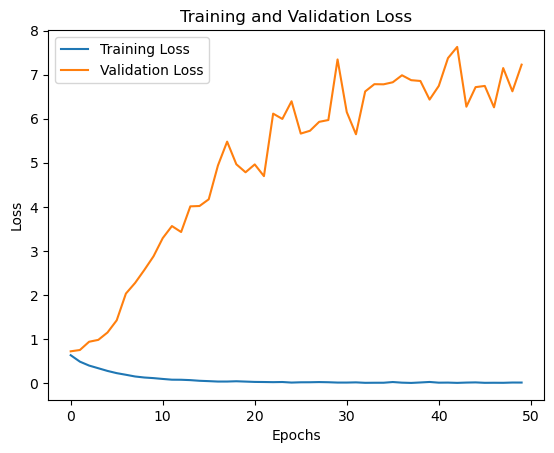

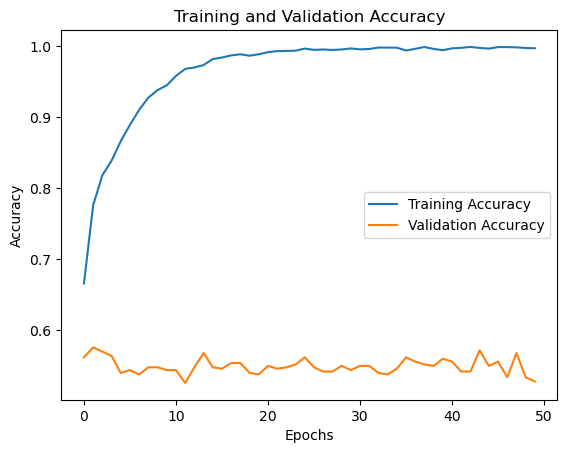

In [26]:
plot_history(history_model_1)

In [27]:
get_metrics(model_1)

32/32 [==============================] - 0s 11ms/step - loss: 7.3246 - accuracy: 0.5560 - precision: 0.5958 - recall: 0.2918 - f1_m: 0.3818


2023-04-21 16:53:07.495129: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 5117952000 exceeds 10% of free system memory.


16/16 [==============================] - 0s 10ms/step - loss: 7.2266 - accuracy: 0.5280 - precision: 0.5407 - recall: 0.2955 - f1_m: 0.3777
#######################################################################################################
#######################################################################################################
Following are the TEST metrics associated with the model

Test loss: 7.324632167816162

Test acuuracy: 0.5559999942779541

Test precision: 0.5958333611488342

Test recall: 0.2918367385864258

Test F1-Score: 0.38176876306533813

 8/32 [======>.......................] - ETA: 0s 

2023-04-21 16:53:15.406432: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-21 16:53:15.407638: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-21 16:53:15.408459: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

32/32 [==============================] - 1s 7ms/step
              precision    recall  f1-score   support

           0       0.54      0.81      0.65       510
           1       0.60      0.29      0.39       490

    accuracy                           0.56      1000
   macro avg       0.57      0.55      0.52      1000
weighted avg       0.57      0.56      0.52      1000

#######################################################################################################
#######################################################################################################
Following are the TRAIN metrics associated with the model

Train loss: 0.009517771191895008

Train acuuracy: 0.9977647066116333

Train precision: 0.998670220375061

Train recall: 0.995031476020813

Train F1-Score: 0.997039794921875

266/266 [==============================] - 2s 7ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5481
           1   

### Model - 2

In [13]:
model2 = return_model_2()
history_model2 = model2.fit([train_images, train_seq], train_labels, epochs=50, batch_size=32, validation_data=([dev_images, dev_seq], dev_labels))

2023-04-21 19:00:15.662995: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46662 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:81:00.0, compute capability: 8.6


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 256)]        0           []                               
                                                                                                  
 vgg16 (Functional)             (None, 7, 7, 512)    14714688    ['input_2[0][0]']                
                                                                                                  
 embedding (Embedding)          (None, 256, 100)     1200000     ['input_3[0][0]']            

2023-04-21 19:00:22.178190: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-21 19:00:22.179260: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-21 19:00:22.180043: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/50


2023-04-21 19:00:26.758572: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-21 19:00:26.759642: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-21 19:00:26.760500: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

  1/266 [..............................] - ETA: 14:34 - loss: 0.8760 - accuracy: 0.5000 - precision: 0.3182 - recall: 0.8750 - f1_m: 0.4667

2023-04-21 19:00:29.753170: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


266/266 [==============================] - ETA: 0s - loss: 0.7051 - accuracy: 0.6309 - precision: 0.3540 - recall: 0.0474 - f1_m: 0.0343

2023-04-21 19:00:41.803100: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-21 19:00:41.804429: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-21 19:00:41.805249: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

266/266 [==============================] - 16s 48ms/step - loss: 0.7051 - accuracy: 0.6309 - precision: 0.3540 - recall: 0.0474 - f1_m: 0.0343 - val_loss: 0.6958 - val_accuracy: 0.5060 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/50
266/266 [==============================] - 12s 44ms/step - loss: 0.6648 - accuracy: 0.6448 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 0.7044 - val_accuracy: 0.5060 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/50
266/266 [==============================] - 12s 45ms/step - loss: 0.6563 - accuracy: 0.6449 - precision: 1.0000 - recall: 3.3124e-04 - f1_m: 7.5188e-04 - val_loss: 0.7133 - val_accuracy: 0.5060 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/50
266/266 [==============================] - 12s 45ms/step - loss: 0.6525 - accuracy: 0.6449 - precision: 1.0000 - recall: 3.3124e-04 - f1_m: 5.7837e-04 - val_loss: 0

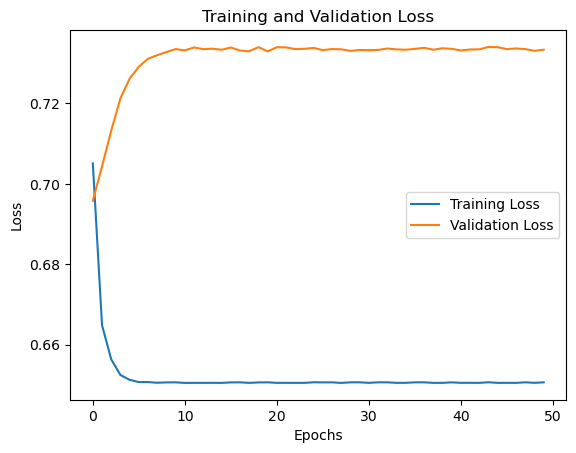

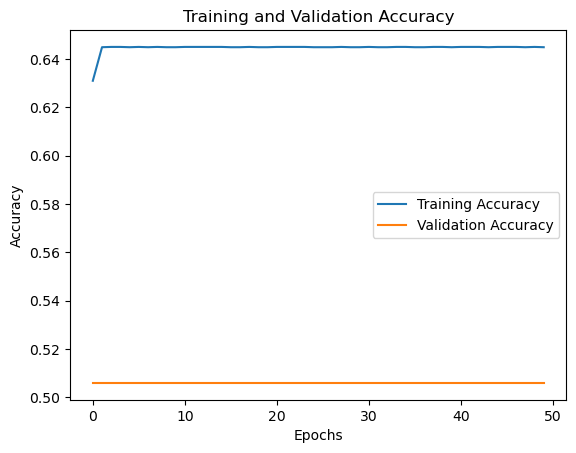

In [15]:
plot_history(history_model2)

In [16]:
get_metrics(model2)

16/16 [==============================] - 1s 39ms/step - loss: 0.7334 - accuracy: 0.5060 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_m: 0.0000e+00
#######################################################################################################
#######################################################################################################
Following are the TEST metrics associated with the model

Test loss: 0.7309843897819519

Test acuuracy: 0.5099999904632568

Test precision: 0.0

Test recall: 0.0

Test F1-Score: 0.0

 1/32 [..............................] - ETA: 17s

2023-04-21 19:11:04.741476: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-21 19:11:04.742684: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-21 19:11:04.743507: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

32/32 [==============================] - 2s 35ms/step
              precision    recall  f1-score   support

           0       0.51      1.00      0.68       510
           1       0.00      0.00      0.00       490

    accuracy                           0.51      1000
   macro avg       0.26      0.50      0.34      1000
weighted avg       0.26      0.51      0.34      1000

#######################################################################################################
#######################################################################################################
Following are the TRAIN metrics associated with the model

Train loss: 0.6504706740379333

Train acuuracy: 0.6449411511421204

Train precision: 1.0

Train recall: 0.00033123549656011164

Train F1-Score: 0.0006265663541853428



/home/prashant21227/anaconda3/envs/prash/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/prashant21227/anaconda3/envs/prash/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/prashant21227/anaconda3/envs/prash/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

266/266 [==============================] - 10s 36ms/step
              precision    recall  f1-score   support

           0       0.64      1.00      0.78      5481
           1       1.00      0.00      0.00      3019

    accuracy                           0.64      8500
   macro avg       0.82      0.50      0.39      8500
weighted avg       0.77      0.64      0.51      8500

#######################################################################################################
#######################################################################################################
Following are the DEV metrics associated with the model

Train loss: 0.7333693504333496

Train acuuracy: 0.5059999823570251

Train precision: 0.0

Train recall: 0.0

Train F1-Score: 0.0

16/16 [==============================] - 1s 36ms/step
              precision    recall  f1-score   support

           0       0.51      1.00      0.67       253
           1       0.00      0.00      0.00       247

   

/home/prashant21227/anaconda3/envs/prash/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/prashant21227/anaconda3/envs/prash/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/prashant21227/anaconda3/envs/prash/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

### Model - 3

In [17]:
model3 = return_model_3()
history_model3 = model3.fit([train_images, train_seq], train_labels, epochs=50, batch_size=32, validation_data=([dev_images, dev_seq], dev_labels))

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_6 (InputLayer)           [(None, 256)]        0           []                               
                                                                                                  
 vgg16 (Functional)             (None, 7, 7, 512)    14714688    ['input_5[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 256, 128)     1536000     ['input_6[0][0]']          

2023-04-21 19:11:31.303092: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-21 19:11:31.304235: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-21 19:11:31.305039: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/50


2023-04-21 19:11:35.511800: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-21 19:11:35.513120: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-21 19:11:35.513995: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

265/266 [============================>.] - ETA: 0s - loss: 0.7233 - accuracy: 0.6368 - precision: 0.3245 - recall: 0.0202 - f1_m: 0.0202

2023-04-21 19:11:48.392735: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-21 19:11:48.393869: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-21 19:11:48.394706: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

266/266 [==============================] - 14s 47ms/step - loss: 0.7231 - accuracy: 0.6371 - precision: 0.3245 - recall: 0.0202 - f1_m: 0.0202 - val_loss: 0.7154 - val_accuracy: 0.5060 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/50
266/266 [==============================] - 12s 46ms/step - loss: 0.6151 - accuracy: 0.6452 - precision: 0.5882 - recall: 0.0033 - f1_m: 0.0062 - val_loss: 0.7061 - val_accuracy: 0.5100 - val_precision: 0.7500 - val_recall: 0.0121 - val_f1_m: 0.0237
Epoch 3/50
266/266 [==============================] - 12s 46ms/step - loss: 0.5611 - accuracy: 0.6616 - precision: 0.6367 - recall: 0.1103 - f1_m: 0.1486 - val_loss: 0.6930 - val_accuracy: 0.5480 - val_precision: 0.6154 - val_recall: 0.2267 - val_f1_m: 0.3356
Epoch 4/50
266/266 [==============================] - 12s 46ms/step - loss: 0.5163 - accuracy: 0.7146 - precision: 0.7021 - recall: 0.3412 - f1_m: 0.4448 - val_loss: 0.7072 - val_accuracy: 0.5840 - val_precision: 0.6021

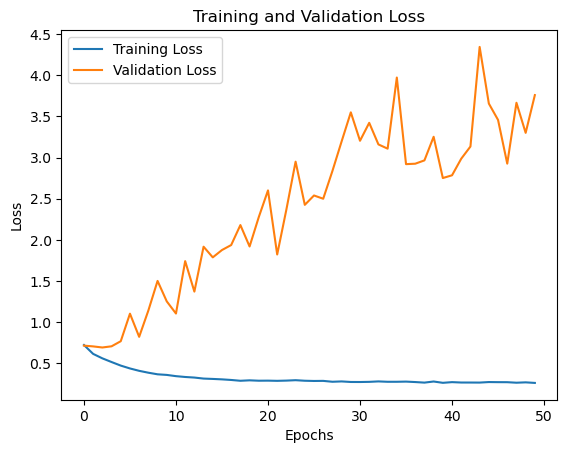

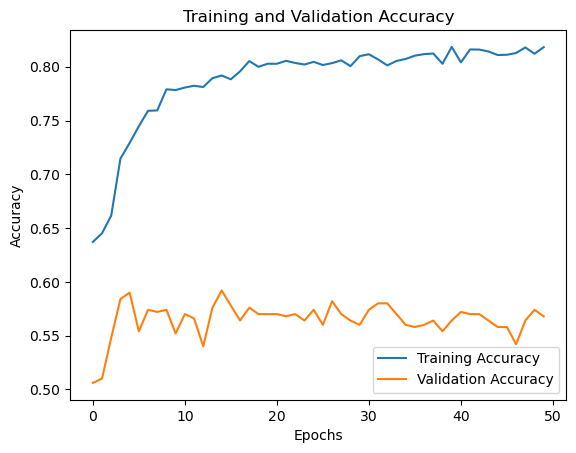

In [18]:
plot_history(history_model3)

In [19]:
get_metrics(model3)

16/16 [==============================] - 1s 39ms/step - loss: 3.7582 - accuracy: 0.5680 - precision: 0.6115 - recall: 0.3441 - f1_m: 0.4410
#######################################################################################################
#######################################################################################################
Following are the TEST metrics associated with the model

Test loss: 3.3704614639282227

Test acuuracy: 0.5770000219345093

Test precision: 0.6254681944847107

Test recall: 0.34081631898880005

Test F1-Score: 0.4235880970954895

 1/32 [..............................] - ETA: 18s

2023-04-21 19:22:07.428195: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-21 19:22:07.429434: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-21 19:22:07.430232: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

32/32 [==============================] - 2s 35ms/step
              precision    recall  f1-score   support

           0       0.56      0.80      0.66       510
           1       0.63      0.34      0.44       490

    accuracy                           0.58      1000
   macro avg       0.59      0.57      0.55      1000
weighted avg       0.59      0.58      0.55      1000

#######################################################################################################
#######################################################################################################
Following are the TRAIN metrics associated with the model

Train loss: 0.048057109117507935

Train acuuracy: 0.9784705638885498

Train precision: 0.9467548727989197

Train recall: 0.9953626990318298

Train F1-Score: 0.9680393934249878

266/266 [==============================] - 10s 36ms/step
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      5481
         

### Saving model 3 because it performs the best

In [20]:
import pickle
filename = 'task_3_model_3.pkl'
pickle.dump(model3, open(filename, 'wb'))

In [ ]:
"""

Explanation:
    This multimodal model performs better than both image-only and text-only models 
    because it can leverage the information from both modalities to make a better decision.
    The accuracy and F1 score of this model is higher than those of the unimodal models.
    
"""

### Task 4: tSNE Plots

##### tSNE on text features

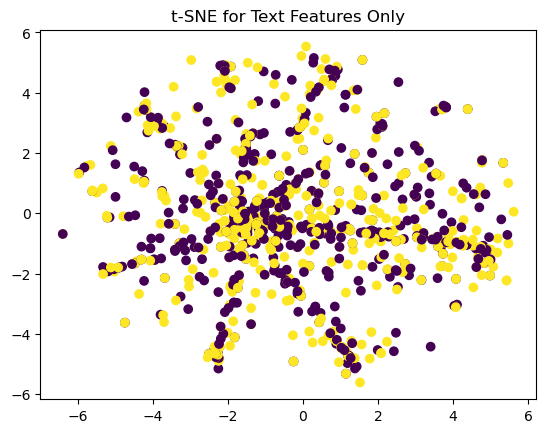

In [20]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Perform t-SNE on text features
tsne = TSNE(n_components=2, random_state=42,  perplexity = 300)
text_tsne = tsne.fit_transform(test_seq)

# Plot the t-SNE for text features only
plt.scatter(text_tsne[:, 0], text_tsne[:, 1], c=test_labels)
plt.title('t-SNE for Text Features Only')
plt.show()

##### tSNE on Image Features

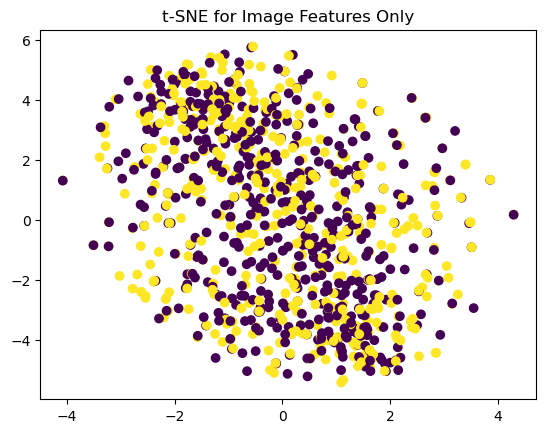

In [19]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

# Reshape the images into a 2D array
n_samples = test_images.shape[0]
image_features = test_images.reshape((n_samples, -1))

# Perform t-SNE on image features
tsne = TSNE(n_components=2, random_state=42,  perplexity = 300)
image_tsne = tsne.fit_transform(image_features)

# Plot the t-SNE for image features only
plt.scatter(image_tsne[:, 0], image_tsne[:, 1], c=test_labels)
plt.title('t-SNE for Image Features Only')
plt.show()


#### Combined features

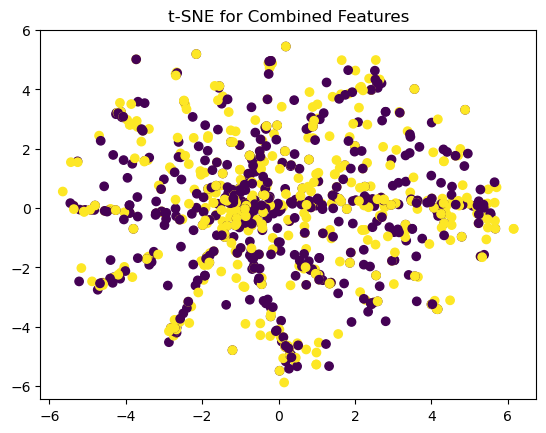

In [18]:
import numpy as np

# Concatenate text and image features
combined_features = np.concatenate((test_seq, image_features), axis=1)

# Perform t-SNE on combined features
tsne = TSNE(n_components=2, random_state=42, perplexity = 300)
combined_tsne = tsne.fit_transform(combined_features)

# Plot the t-SNE for combined features
plt.scatter(combined_tsne[:, 0], combined_tsne[:, 1], c=test_labels)
plt.title('t-SNE for Combined Features')
plt.show()
